In [1]:
# Set parameters
import argparse
parser = argparse.ArgumentParser()

# Data
parser.add_argument(
    '-N_Q', '--N_samples_Q', type=int, default=50, help='total number of target samples',
)
parser.add_argument(
    '-N_P', '--N_samples_P', type=int, default=50, help='total number of prior samples',
)
parser.add_argument(
    '-N_dim', type=int, help='dimension of input data',
)
parser.add_argument(
    '-N_latent_dim', type=int, help='dimension of latent space',
)
parser.add_argument(
    '-N_project_dim', type=int, help='dimension of PCA projected space on input',
)
parser.add_argument(
    '-sample_latent', type=bool, default = False, help='True: sample in the latent space, False: sample in the physical space',
)
# Dataset property
parser.add_argument(
    '--dataset', type=str, default='Learning_gaussian', choices=['Lorenz63', 'Learning_gaussian', 'Mixture_of_gaussians', 'Mixture_of_gaussians2','Mixture_of_gaussians3','Mixture_of_gaussians4', 'Stretched_exponential', 'Learning_student_t', 'Mixture_of_student_t', 'Mixture_of_student_t_submnfld', 'Mixture_of_gaussians_submnfld','MNIST', 'CIFAR10', 'MNIST_switch', 'CIFAR10_switch', 'MNIST_ae', 'MNIST_ae_switch','CIFAR10_ae',  'Mixture_of_gaussians_submnfld_ae','BreastCancer', '1D_pts', '2D_pts','1D_dirac2gaussian', '1D_dirac2uniform',]
)
parser.add_argument(
    '-y0', type=float, nargs="+", default=[1.0,2.0, 2.0]
)
parser.add_argument(
    '-beta', type=float, help='gibbs distribution of -|x|^\beta',
)
parser.add_argument(
    '-sigma_P', type=float, default=0.5, help='std of initial gaussian distribution',
)
parser.add_argument(
    '-sigma_Q', type=float, default=1.0, help='std of target gaussian distribution',
)
parser.add_argument(
    '-nu', type=float, help='df of target student-t distribution',
)
parser.add_argument(
    '-interval_length', type=float, help='interval length of the uniform distribution',
)
parser.add_argument(
    '-label', type=int, nargs="+", help='class label of image data',
)
parser.add_argument(
    '-pts_P', type=float, nargs="+", default=[10.0,]
)
parser.add_argument(
    '-pts_Q', type=float, nargs="+", default=[0.0,]
)
parser.add_argument(
    '-pts_P_2', type=float, nargs="+", default=[0.0,]
)
parser.add_argument(
    '-pts_Q_2', type=float, nargs="+", default=[0.0,]
)
parser.add_argument(
    '--random_seed', type=int, default=0, help='random seed for data generator',
)


# (f, Gamma)-divergence
parser.add_argument(
    '--f', type=str, default='KL', choices=['KL', 'alpha', 'reverse_KL', 'JS'],
)
parser.add_argument(
    '-alpha', type=float, help='parameter value for alpha divergence',
)    
parser.add_argument( 
    '--formulation', type=str, default='DV', choices=['LT', 'DV'], help='LT or DV in case of f=KL, otherwise, keep LT',
)
parser.add_argument(
    '--Gamma', type=str, default='Lipshitz', choices=['Lipshitz'],
)
parser.add_argument(
    '-L', type=float, default=1.0, help='Lipshitz constant: default=inf w/o constraint',
)
parser.add_argument(
    '--reverse', type=bool, default=False, help='True -> D(Q|P), False -> D(P|Q)',
)
parser.add_argument(
    '--constraint', type=str, default='hard', choices=['hard', 'soft'],
)
parser.add_argument(
    '-lamda', type=float, default=0.05, help='coefficient on soft constraint',
)


# RKHS definition <phi>
parser.add_argument(
    '--kernel', type=str, default='gaussian', choices=['gaussian'],
)
parser.add_argument(
    '-bandwidth', type=float, default = 20.0, help='gaussian kernel bandwidth',
)


# training parameters
parser.add_argument(
    '-ep', '--epochs', type=int, default=300, help='# updates for P',
)
parser.add_argument(
    '-ep_phi', '--epochs_phi', type=int, default=20, help='# updates to find phi*',
)
parser.add_argument(
    '--optimizer', type=str, choices=['Newton', 'BFGS','Gradient_Ascent'], default='Gradient_Ascent', help='optimization method for phi',
)
parser.add_argument(
    '--ode_solver', type=str, choices=['forward_euler', 'AB2', 'AB3', 'AB4', 'AB5', 'ABM1', 'Heun', 'ABM2', 'ABM3', 'ABM4', 'ABM5', 'RK4', 'ode45' ], default='forward_euler', help='ode solver for particle ode',
)
parser.add_argument(
    '-mobility', type=str, help='problem dependent mobility function\nRecommendation: MNIST - bounded',
)
parser.add_argument(
    '-lr_P_decay', type=str, choices=['rational', 'step',], help='delta t decay',
)
parser.add_argument(
    '--lr_P', type=float, default=0.5, help='lr for P',
)
parser.add_argument(
    '--lr_phi', type=float, default=0.005, help='lr for phi',
)
parser.add_argument(
    '--exp_no', type=str, default='rkhs2', help='short experiment name under the same data',
)
parser.add_argument(
    '--mb_size_P', type=int, default=50, help='mini batch size for the moving distribution P',
)
parser.add_argument(
    '--mb_size_Q', type=int, default=50, help='mini batch size for the target distribution Q',
)


# save/display 
parser.add_argument(
    '--save_iter', type=int, default=10, help='save results per each save_iter',
)
parser.add_argument(
    '--plot_result', type=bool, default=True, help='True -> show plots',
)
parser.add_argument(
    '--plot_intermediate_result', type=bool, default=False, help='True -> save intermediate plots',
)

_StoreAction(option_strings=['--plot_intermediate_result'], dest='plot_intermediate_result', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, required=False, help='True -> save intermediate plots', metavar=None)

In [2]:
import os
import numpy as np
import re
from functools import partial

In [3]:
# input parameters --------------------------------------
p, unknown = parser.parse_known_args()
param = vars(p)

if p.alpha:    
    par = [p.alpha]
    p.exptype = '%s=%05.2f-%s' % (p.f, p.alpha, p.Gamma)
else: 
    par = []
    p.exptype = '%s-%s' % (p.f, p.Gamma)
if p.L == None:
    p.expname = '%s_%s' % (p.exptype, 'inf')
else:
    p.expname = '%s_%.4f' % (p.exptype, p.L)

In [4]:
# Data generation ----------------------------------------
from util.generate_data import generate_data
# X_ ~ Q, Y_ ~ P_0
p, X_, Y_, X_label, Y_label = generate_data(p)
       

In [5]:
# Discriminator learning  -----------------------------------------
# kernel for RKHS
def gaussian_kernel(x, y, bandwidth):
    return np.exp(-np.sum(((x-y)/bandwidth)**2)/2)
    
def kernel(X_, Y_, bandwidth=1):
    res = np.zeros((X_.shape[0],Y_.shape[0]))
    for i, x in enumerate(X_):
        for j, y in enumerate(Y_):
            res[i,j] = gaussian_kernel(x, y, bandwidth=bandwidth)
    return res
    
k = partial(kernel, bandwidth=p.bandwidth)

In [6]:
# (Discriminator) Loss ----------------------------------------------
if p.f == "KL":
    f = lambda x: x * np.log(x)
    f_star = lambda x: np.exp(x - 1)
    f_star_prime = lambda x: np.exp(x - 1)
    f_star_2prime = lambda x: np.exp(x - 1)
elif p.f == 'alpha':
    f = lambda x: (x**p.alpha - 1)/(p.alpha*(p.alpha-1))
    f_star = lambda x: 1/p.alpha*(1/(p.alpha-1) + ((p.alpha-1)*np.maximum(x,0))**(p.alpha/(p.alpha-1)))
    f_star_prime = lambda x: x**(1/(p.alpha-1)) if x>0 else 0
    f_star_2prime = lambda x: 1/(p.alpha-1)*x**(1/(p.alpha-1)-1)


def loss(X_, Y_, Z_, alpha, lamda):
# loss = \sum_i alpha_i f'(n*alpha_i) - \sum_i f^*(f'(n*alpha_i))/n +
#        1/2* (\sum_i \sum_j k(Y_i, Y_j)/n^2 - 2/n* alpha_i * k(X_i, Y_j) + alpha_i*alpha_j * K(X_i, X_j)
    N_Y = Y_.shape[0]
    N_X = X_.shape[0]
    N_Z = 1.0#Z_.shape[0]
    
    regularizer = -p.lamda/2*max((alpha @ k(Z_, Z_) @ alpha/(N_Z*p.L)**2 -1,0))
    return np.sum(k(Y_, Z_) @ alpha)/(N_Z*N_Y) - np.sum(f_star(k(X_, Z_) @ alpha/N_Z))/N_X +regularizer
    
def grad_loss(X_, Y_, Z_, alpha):
    N_Y = Y_.shape[0]
    N_X = X_.shape[0]
    N_Z = 1.0#Z_.shape[0]
    
    grad_regularizer = 0
    if alpha @ k(Z_, Z_) @ alpha > (N_Z*p.L)**2:
        grad_regularizer = p.lamda/(N_Z*p.L)**2 * k(Z_, Z_) @ alpha
    #print(np.round(np.sum(k(Y_, Z_), axis=0)/(N_Z*N_Y),4), np.round(k(Z_, X_) @ f_star_prime(k(X_, Z_) @ alpha/N_Z)/(N_Z*N_X),4), np.round(grad_regularizer,4))
    return np.sum(k(Y_, Z_), axis=0)/(N_Z*N_Y) - k(Z_, X_) @ f_star_prime(k(X_, Z_) @ alpha/N_Z)/(N_Z*N_X) - grad_regularizer
    
def hess_loss(X_, Y_, Z_, alpha):
    N_Y = Y_.shape[0]
    N_X = X_.shape[0]
    N_Z = 1.0#Z_.shape[0]
    
    hess_regularizer = 0
    if alpha @ k(Z_, Z_) @ alpha > (N_Z*p.L)**2:
        hess_regularizer =  p.lamda/(N_Z*p.L)**2 *k(Z_, Z_)
    
    return k(Z_, X_) @ np.diag(f_star_2prime(k(X_, Z_)@alpha)) @ k(X_, Z_)/(N_X * N_Z**2) - hess_regularizer
 
def Gradient_Aescent(alpha, lr_phi, grad):
    return alpha + lr_phi*grad
    
def Newton(alpha, lr_phi, grad, hess):
    return alpha - lr_phi*np.linalg.inv(hess) @ grad
    
def BFGS(alpha, lr_phi, grad, B_inv, X_, Y_, Z_):
    #print("Eigenvalues of inverse hessian:", np.linalg.eigvals(B_inv))
    p_k = - B_inv @ grad
    s_k = lr_phi * p_k
    alpha = alpha + s_k
    y_k = grad_loss(X_, Y_, Z_, alpha) - grad
    B_inv += (np.dot(s_k, y_k) + np.sum((B_inv * np.outer(y_k, y_k)).flatten()))/np.dot(s_k, y_k)**2 * np.outer(s_k, s_k) - (B_inv @ np.outer(y_k, s_k.T) + np.outer(s_k, y_k) @ B_inv)/np.dot(s_k, y_k)
    return alpha, B_inv
        

In [7]:
# Transporting particles --------------------------------------------
# gradient of first variation
def grad_gaussian_kernel(x, y, bandwidth):
# gradient with respect to first argument (x) of gaussian kernel k(x,y)
    return - (x-y)/bandwidth**2 * gaussian_kernel(x,y,bandwidth)
    
def grad_kernel(X_, Y_, bandwidth):
    res = np.zeros((X_.shape[0], Y_.shape[1], Y_.shape[0]))
    for i, x in enumerate(X_):
        for j, y in enumerate(Y_):
            res[i,:,j] = grad_gaussian_kernel(x, y, bandwidth)
    return res
    
grad_k = partial(grad_kernel, bandwidth=p.bandwidth)

def loss_first_variation(y, Z_, alpha):
    N_Z = 1.0#Z_.shape[0]
    return k(y, Z_) @ alpha/N_Z
    
def grad_loss_first_variation(y, Z_, alpha):
    N_Z = 1.0#Z_.shape[0]
    return grad_k(y, Z_) @ alpha/N_Z

In [8]:
# ODE solver setting
#from util.transport_particles import calc_vectorfield, solve_ode
dPs = []
if p.ode_solver in ['forward_euler', 'AB2', 'AB3', 'AB4', 'AB5']:
    aux_params = []
else:
    aux_params = {'parameters': parameters, 'phi': phi, 'Q': Q, 'lr_phi': lr_phi,'epochs_nn': p.epochs_nn, 'loss_par': loss_par, 'NN_par': NN_par, 'data_par': data_par, 'optimizer': p.optimizer}

# Applying mobility to particles
#if p.mobility == 'bounded':
    #from util.construct_NN import bounded_relu  # mobility that bounding particles (For image data)
        
# Train setting
lr_P_init = p.lr_P # Assume that deltat = deltat(t)
if p.ode_solver == "DOPRI5": # deltat = deltat(x,t)
    lr_P_init = [p.lr_P]*p.N_samples_P
    # Low dimensional example=> rank 2, Image example=> rank 4
    for i in range(1, Y_.ndim):
        lr_P_init = np.expand_dims(lr_P_init, axis=i)
lr_P = lr_P_init
lr_Ps = []

In [9]:
# Save & plot settings -----------------------------------------------
# Metrics to calculate
from util.evaluate_metric import calc_ke, calc_grad_phi
if "MNIST" in p.dataset or "CIFAR10" in p.dataset:
    from util.evaluate_metric import calc_fid
trajectories = []
vectorfields = []
divergences = []
KE_Ps = []
FIDs = []

# saving/plotting parameters
if p.save_iter >= p.epochs:
    p.save_iter = 1

if p.plot_result == True:
    from plot_result import plot_result

p.expname = p.expname+'_%04d_%04d_%02d_%s' % (p.N_samples_Q, p.N_samples_P, p.random_seed, p.exp_no)
filename = p.dataset+'/%s.pickle' % (p.expname)

if p.plot_intermediate_result == True:
    if 'gaussian' in p.dataset and 'Extension' not in p.dataset:
         r_param = p.sigma_Q
    elif 'student_t' in p.dataset:
        r_param = p.nu
    elif p.dataset == 'Extension_of_gaussian':
        r_param = p.a
    else:
        r_param = None
    
# additional plots for simple low dimensional dynamics
if p.N_dim == 1:
    xx = np.linspace(-10, 10, 300)
    phis = []
elif p.N_dim == 2:#'2D' in p.dataset:
    xx = np.linspace(-10, 10, 40)
    yy = np.linspace(-10, 10, 40)
    XX, YY = np.meshgrid(xx, yy)
    xx = np.concatenate((np.reshape(XX, (-1,1)), np.reshape(YY, (-1,1))), axis=1)
    phis = []
    

In [10]:
# Train ---------------------------------------------------------------
import time 
t0 = time.time()

P, Q = Y_, X_
alpha = np.zeros(int(p.N_samples_Q/2)+int(p.N_samples_P/2))
for it in range(1, p.epochs+1): # Loop for updating particles P
    #k = partial(kernel, bandwidth=p.bandwidth*np.exp(-(it-1)*1.5/p.epochs))
    #grad_k = partial(grad_kernel, bandwidth=p.bandwidth*np.exp(-(it-1)*1.5/p.epochs))
    #print(p.bandwidth*np.exp(-(it-1)*1.5/p.epochs))
    
    Q_idx_for_R = np.random.choice(p.N_samples_Q, int(p.N_samples_Q/2), replace=False)
    P_idx_for_R = np.random.choice(p.N_samples_P, int(p.N_samples_P/2), replace=False)
    R = np.vstack((Q[Q_idx_for_R], P[P_idx_for_R]))
    #R = np.random.uniform(low=-3.0, high = 13.0, size=(len(alpha), p.N_dim))
    for in_it in range(p.epochs_phi):
        grad = grad_loss(Q, P, R, alpha)
        if p.optimizer == 'Gradient_Ascent':
            alpha = Gradient_Aescent(alpha, p.lr_phi, grad)
        elif p.optimizer == 'Newton':
            hess = hess_loss(Q, P, R, alpha)
            alpha = Newton(alpha, p.lr_phi, grad, hess)
        elif p.optimizer == 'BFGS':
            if in_it == 0:
                #hess = hess_loss(Q, P, R, alpha)
                hess = np.identity(len(alpha))
                B_inv = np.linalg.inv(hess)
                alpha, B_inv = BFGS(alpha, p.lr_phi, grad, B_inv, Q, P, R)
    current_loss = loss(Q, P, R, alpha, p.lamda)
            
    dP = grad_loss_first_variation(P, R, alpha)
    dPs.append(dP)
    
    P = P - lr_P * dPs[-1]
    '''
    if p.ode_solver == "DOPRI5": # deltat adjust
        P, dPs, dP, lr_P = solve_ode(P, lr_P, dPs, p.ode_solver, aux_params) # update P
    else:
        P, dPs, dP = solve_ode(P, lr_P, dPs, p.ode_solver, aux_params) # update P
    '''

    if p.mobility == 'bounded':
        P = bounded_relu(P)
     
    lr_Ps.append(lr_P)
    # adjust learning rates
    #if it>=100:
    #    lr_P = decay_learning_rate(lr_P, p.lr_P_decay, {'epochs': p.epochs-100, 'epoch': it-100, 'KE_P': KE_P})
    
    # save results
    divergences.append(current_loss)
    KE_P = calc_ke(dP, p.N_samples_P)
    KE_Ps.append(KE_P)
    grad_phi = calc_grad_phi(dP)
    #print("grad", grad_phi)
    
    if p.epochs<=100 or it%p.save_iter == 0:
        if p.dataset in ['BreastCancer',]:
            trajectories.append(P*10)
        else:
            trajectories.append(P)
        if np.prod(p.N_dim) < 500:
            vectorfields.append(dP)
        elif np.prod(p.N_dim) >= 784:  # image data
            FIDs.append( calc_fid(pred=P, real=Q) )
    
    # display intermediate results
    if it % (p.epochs/10) == 0:
    #if it in [5, 50, 500, 1000, 2000, 3000, 4000, 5000]:
        display_msg = 'iter %6d: loss = %.10f, kinetic energy of P = %.10f, average learning rate for P = %.6f' % (it, current_loss, KE_P, np.mean(lr_P))
        if np.prod(p.N_dim) >= 784:
            display_msg = display_msg + ', FID = %.3f' % FIDs[-1]
        print(display_msg)
        print("grad", grad_phi)
        
        if p.plot_intermediate_result == True:
            data = {'trajectories': trajectories, 'divergences': divergences, 'KE_Ps': KE_Ps, 'FIDs':FIDs, 'X_':X_, 'Y_':Y_, 'X_label':X_label, 'Y_label':Y_label, 'dt': lr_Ps, 'dataset': p.dataset, 'r_param': r_param, 'vectorfields': vectorfields, 'save_iter':p.save_iter}
            if p.N_dim ==2:
                data.update({'phi': phi, 'W':W, 'b':b, 'NN_par':NN_par})
            plot_result(filename, intermediate=True, epochs = it, iter_nos = None, data = data, show=False)
        
        '''
        if np.prod(p.N_dim) <= 2:
            zz = phi(xx,None, W,b,NN_par).numpy()
            zz = np.reshape(zz, -1)
            phis.append(zz)
        '''

total_time = time.time() - t0
print(f'total time {total_time:.3f}s')

iter     30: loss = 2.2499948686, kinetic energy of P = 0.0213891882, average learning rate for P = 0.500000
grad 0.20609182768050974
iter     60: loss = 1.4162946847, kinetic energy of P = 0.0256886336, average learning rate for P = 0.500000
grad 0.22603079077014254
iter     90: loss = 0.6479992019, kinetic energy of P = 0.0164449582, average learning rate for P = 0.500000
grad 0.18096247733681572
iter    120: loss = 0.2446860205, kinetic energy of P = 0.0068047564, average learning rate for P = 0.500000
grad 0.1164063692876376
iter    150: loss = 0.0897885066, kinetic energy of P = 0.0036716353, average learning rate for P = 0.500000
grad 0.08548845151007041
iter    180: loss = 0.0268317785, kinetic energy of P = 0.0015341882, average learning rate for P = 0.500000
grad 0.055186094991735136
iter    210: loss = 0.0067219686, kinetic energy of P = 0.0004509640, average learning rate for P = 0.500000
grad 0.029700658997256078
iter    240: loss = -0.0023296560, kinetic energy of P = 0.00

Results saved at: Learning_gaussian/KL-Lipshitz_1.0000_1.00_0050_0050_00_rkhs2.pickle


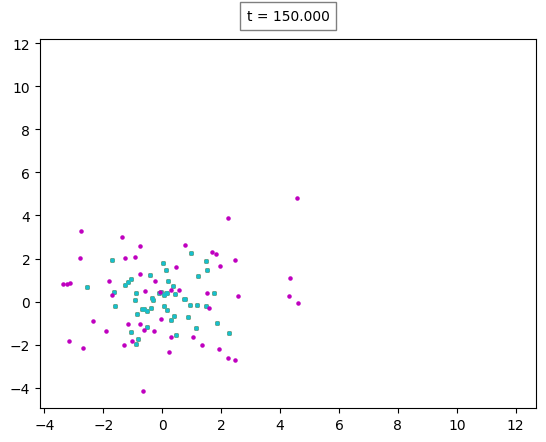

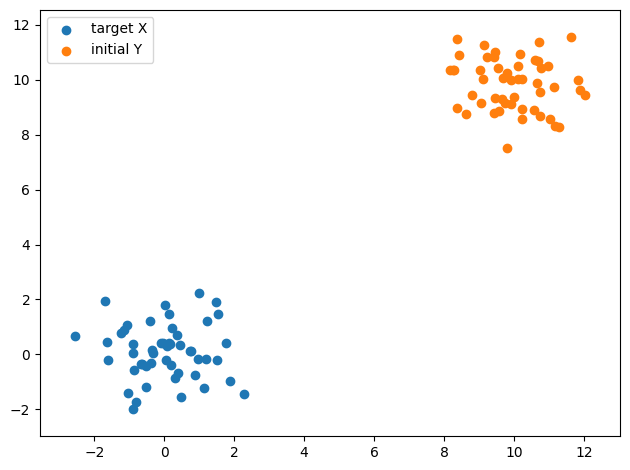

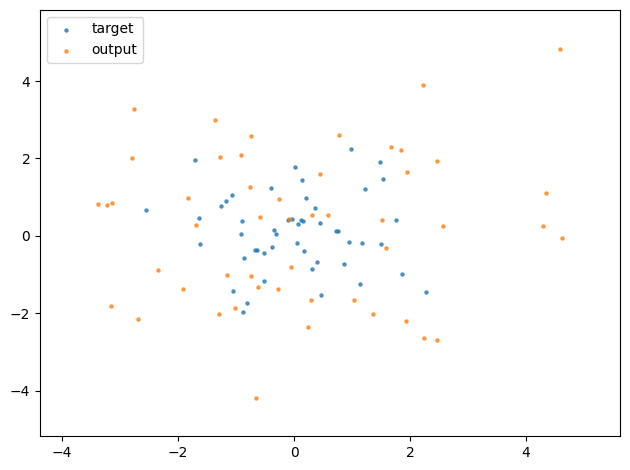

plot_trajectories


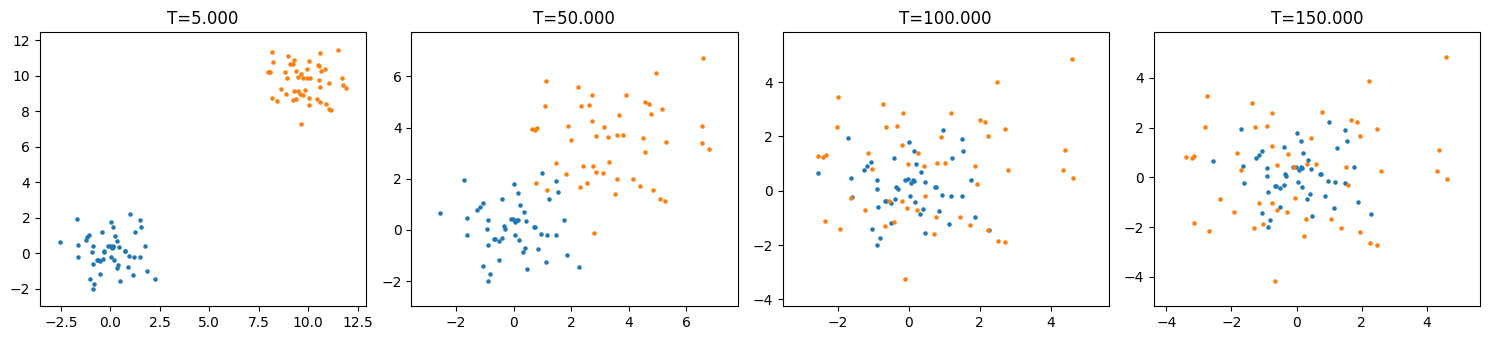

plot divergences
Last: divergences = -0.007049


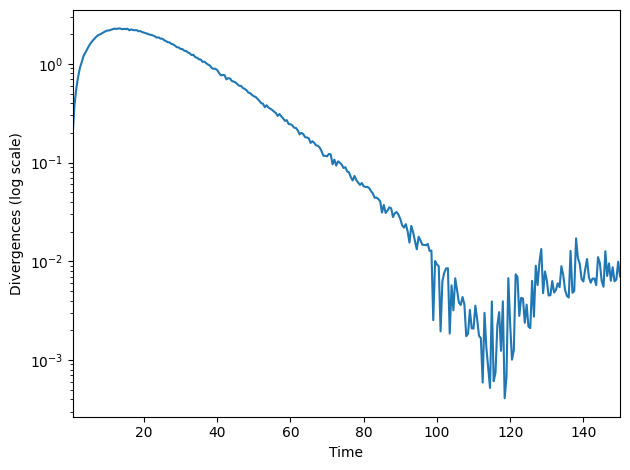

plot KE_Ps
Last: KE_Ps = 0.000100


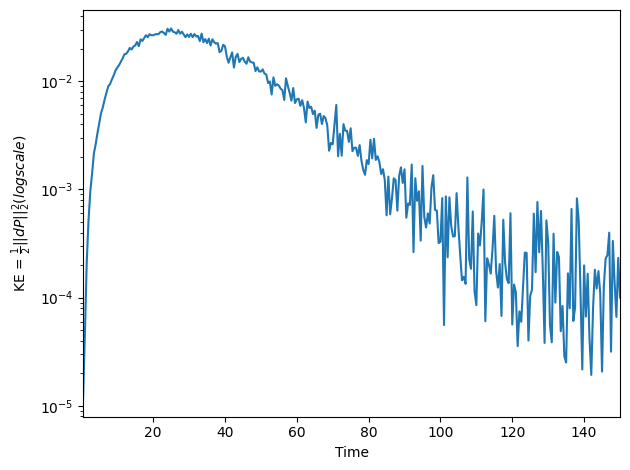

UnboundLocalError: local variable 'phi' referenced before assignment

In [11]:
# Save result ------------------------------------------------------
import pickle
if not os.path.exists(p.dataset):
    os.makedirs(p.dataset)

if '1D' in p.dataset:
    X_ = np.concatenate((X_, np.zeros(shape=X_.shape)), axis=1)
    Y_ = np.concatenate((Y_, np.zeros(shape=Y_.shape)), axis=1)
    
    trajectories = [np.concatenate((x, np.zeros(shape=x.shape)), axis=1) for x in trajectories]
    vectorfields = [np.concatenate((x, np.zeros(shape=x.shape)), axis=1) for x in vectorfields]
        
param.update({'X_': X_, 'Y_': Y_, 'lr_Ps':lr_Ps,})
result = {'trajectories': trajectories, 'vectorfields': vectorfields, 'divergences': divergences, 'KE_Ps': KE_Ps, 'FIDs': FIDs,}

if p.dataset in ['BreastCancer',]:
    np.savetxt("gene_expression_example/GPL570/"+p.dataset+'/output_norm_dataset_dim_%d.csv' % p.N_dim, trajectories[-1], delimiter=",")
        
# Save trained data
with open(filename,"wb") as fw:
    pickle.dump([param, result] , fw)
print("Results saved at:", filename)

# Plot final result
if p.plot_result == True:
    plot_result(filename, intermediate=False, show=True)

<IPython.core.display.Javascript object>


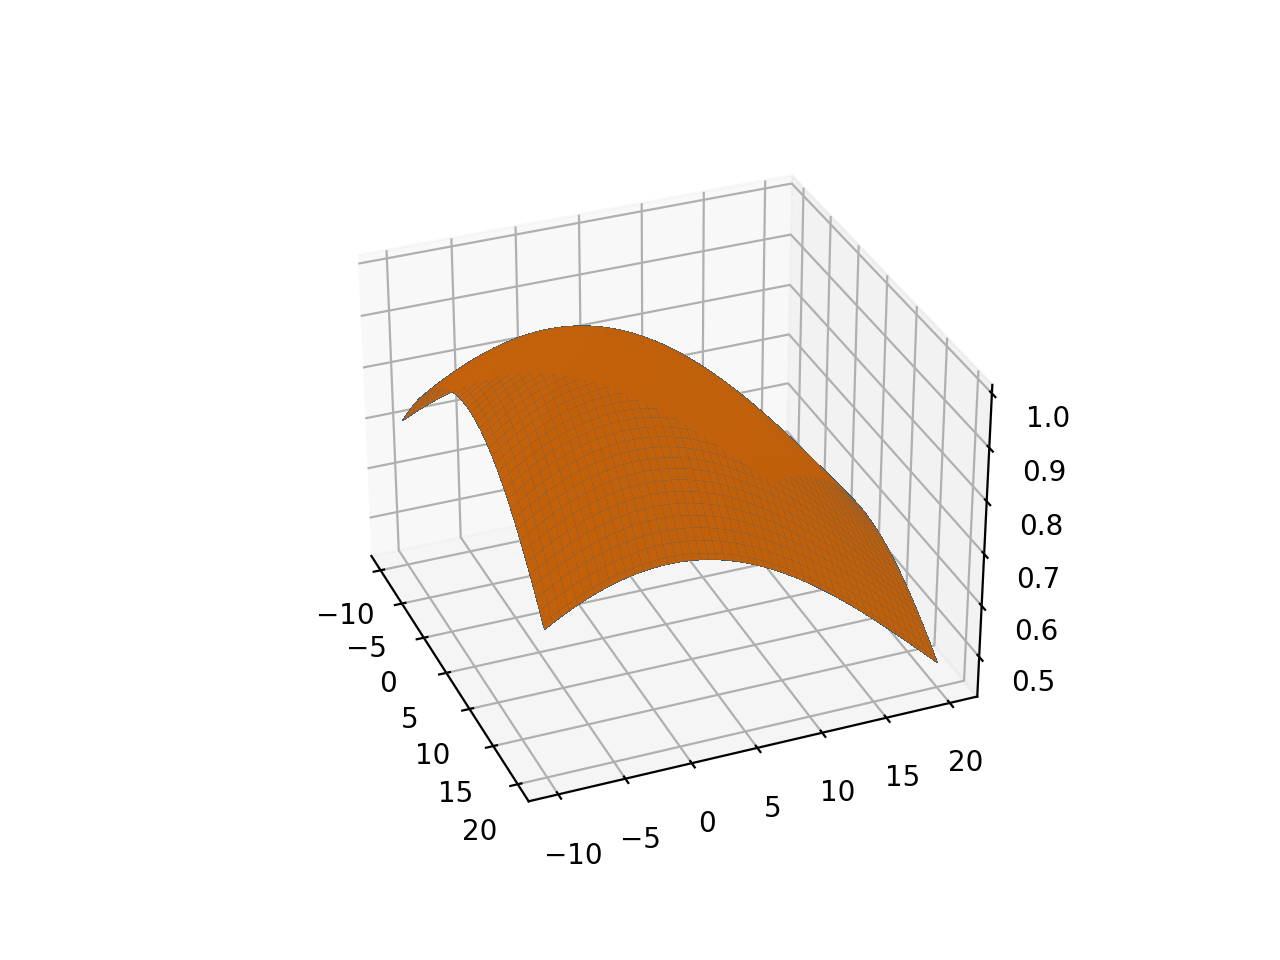

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt

xx = np.linspace(-10, 20, 100)
yy = np.linspace(-10, 20, 100)
XX, YY = np.meshgrid(xx, yy)
y = np.stack((XX, YY), axis=2)
y = np.reshape(y, (-1, 2), order='F')

ZZ = loss_first_variation(y, R, alpha)
ZZ = np.reshape(ZZ, (100, 100), order='F')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX, YY, ZZ,
                       linewidth=0, antialiased=False)
ax.plot_surface(XX, YY, ZZ)
plt.show()